In [40]:
import json
import math

%matplotlib inline
import matplotlib.pyplot as plt
from egraph import Graph, Coordinates, Rng, SparseSgd
import optuna
import networkx as nx
import numpy as np
from scipy.spatial import Delaunay


In [41]:
EDGE_WEIGHT = 30
K_FROM = 1
K_TO = 20

LARGE_DATASET_NAMES = [
    '3elt.json',
    '1138_bus.json',
    'dwt_1005.json',
    'dwt_2680.json',
    'poli.json',
    'qh882.json',
    'USpowerGrid.json',
]
SMALL_DATASET_NAMES = [
    'bull.json',
    'chvatal.json',
    'cubical.json',
    'davis_southern_women.json',
    'desargues.json',
    'diamond.json',
    'dodecahedral.json',
    'florentine_families.json',
    'frucht.json',
    'heawood.json',
    'hoffman_singleton.json',
    'house_x.json',
    'house.json',
    'icosahedral.json',
    'karate_club.json',
    'krackhardt_kite.json',
    'les_miserables.json',
    'moebius_kantor.json',
    'octahedral.json',
    'pappus.json',
    'petersen.json',
    'sedgewick_maze.json',
    'tutte.json',
]

DATASET_NAMES = None
DATASET_NAME = '1138_bus.json'


In [42]:
# グラフの生成・読み込み

def generate_graph_from_nx_graph(nx_graph):
    graph = Graph()

    indices = {}
    for u in nx_graph.nodes:
        indices[u] = graph.add_node(u)
    for u, v in nx_graph.edges:
        graph.add_edge(indices[u], indices[v], (u, v))

    return graph, indices


def graph_preprocessing(nx_graph):
    nx_graph = nx.Graph(nx_graph)

    # グラフを無向グラフに
    nx_graph = nx_graph.to_undirected()

    # エッジの自己ループを除去
    nx_graph.remove_edges_from(list(nx.selfloop_edges(nx_graph)))

    # 最大連結成分を用いる
    largest_cc = max(nx.connected_components(nx_graph), key=len)
    largest_cc_graph = nx_graph.subgraph(largest_cc)

    new_graph = nx.Graph()
    nodes = [str(node_id) for node_id in largest_cc_graph.nodes]
    new_graph.add_nodes_from(nodes)

    # エッジにidと重みを追加
    for i, edge in enumerate(largest_cc_graph.edges):
        new_graph.add_edge(str(edge[0]), str(
            edge[1]), weight=EDGE_WEIGHT, id=str(i))
        # weighted_edges.append((str(edge[0]), str(edge[1]), EDGE_WEIGHT))

    return new_graph


In [43]:
# shape_based_metrics
def generate_delaunay_triangulation_graph(pos):
    index_id_map = {}
    pos_array = []
    for index, node_id in enumerate(pos):
        positions = pos[node_id]
        position = [positions[0], positions[1]]
        pos_array.append(position)
        index_id_map[index] = node_id

    pos_ndarray = np.array(pos_array)
    delaunay = Delaunay(pos_ndarray)

    delaunay_triangulation_graph = nx.Graph()

    nodes = [node_id for node_id in pos]
    delaunay_triangulation_graph.add_nodes_from(nodes)

    weighted_edges = []
    for n in delaunay.simplices:
        n0 = n[0]
        n1 = n[1]
        n2 = n[2]
        weighted_edges.append(
            (index_id_map[n0], index_id_map[n1], EDGE_WEIGHT))
        weighted_edges.append(
            (index_id_map[n0], index_id_map[n2], EDGE_WEIGHT))
        weighted_edges.append(
            (index_id_map[n1], index_id_map[n2], EDGE_WEIGHT))
    delaunay_triangulation_graph.add_weighted_edges_from(weighted_edges)

    return delaunay_triangulation_graph


def jaccard_similarity_sum(nx_graph, nx_shape_graph):
    j_s_sum = 0
    for node in nx_graph.nodes:
        g_n = [n for n in nx_graph.neighbors(node)]
        s_n = [n for n in nx_shape_graph.neighbors(node)]
        and_n = list(set(g_n) & set(s_n))
        or_n = list(set(g_n + s_n))

        j_s_sum += len(and_n) / len(or_n)

    return j_s_sum / len(nx_graph.nodes)

# maximize
def shape_based_metrics(nx_graph, pos):
    nx_shape_graph = generate_delaunay_triangulation_graph(pos)

    return jaccard_similarity_sum(nx_graph, nx_shape_graph)


In [44]:
# minimize
def stress(nx_graph, pos, K = 1, L = 1):
    shortest_paths = dict(nx.all_pairs_dijkstra_path_length(nx_graph))
    s = 0
    node_ids = sorted([node_id for node_id in pos])
    for i, sid in enumerate(node_ids):
        for tid in node_ids[i + 1:]:
            norm = np.linalg.norm(np.array(pos[sid]) - np.array(pos[tid]))
            dij = shortest_paths[sid][tid]
            lij = L * dij
            kij = K * dij
            e = (kij * ((norm - lij) ** 2)) / 2

            s += e
    return s


In [45]:
# minimize
def ideal_edge_length(nx_graph, pos):
    s = 0
    for source, target, data in nx_graph.edges(data=True):
        weight = data['weight'] if 'weight' in data else 1
        shortest_path_length = nx.shortest_path_length(
            nx_graph, source, target, data['weight'] if 'weight' in data else None)

        lij = shortest_path_length * weight
        dist = np.linalg.norm(np.array(pos[source]) - np.array(pos[target]))
        s += ((dist - lij) / lij) ** 2

    return s


In [46]:
def is_edge_crossing(p1, p2, p3, p4):
    tc1 = (p1[0] - p2[0]) * (p3[1] - p1[1]) + (p1[1] - p2[1]) * (p1[0] - p3[0])
    tc2 = (p1[0] - p2[0]) * (p4[1] - p1[1]) + (p1[1] - p2[1]) * (p1[0] - p4[0])
    td1 = (p3[0] - p4[0]) * (p1[1] - p3[1]) + (p3[1] - p4[1]) * (p3[0] - p1[0])
    td2 = (p3[0] - p4[0]) * (p2[1] - p3[1]) + (p3[1] - p4[1]) * (p3[0] - p2[0])
    return tc1 * tc2 < 0 and td1 * td2 < 0


def edge_crossing_finder(nx_graph, pos):
    edges = {}
    for s1, t1, attr1 in nx_graph.edges(data=True):
        id1 = attr1['id']
        if id1 not in edges:
            edges[id1] = {}
        for s2, t2, attr2 in nx_graph.edges(data=True):
            id2 = attr2['id']
            crossing = is_edge_crossing(pos[s1], pos[t1], pos[s2], pos[t2])
            edges[id1][id2] = crossing

    return edges


In [47]:
# minimize
def crossing_number(nx_graph, pos, edge_crossing=None):
    if edge_crossing is None:
        edge_crossing = edge_crossing_finder(nx_graph, pos)

    s = 0
    node_ids = sorted([node_id for node_id in edge_crossing])
    for i,sid in enumerate(node_ids):
        for tid in node_ids[i + 1:]:
            if edge_crossing[sid][tid]:
                s += 1

    return s

In [48]:
# maximize
def crossing_angle_maximization(nx_graph, pos, edge_crossing=None):
    if edge_crossing is None:
        edge_crossing = edge_crossing_finder(nx_graph, pos)
    s = 0
    for s1, t1, attr1 in nx_graph.edges(data=True):
        id1 = attr1['id']
        for s2, t2, attr2 in nx_graph.edges(data=True):
            id2 = attr2['id']
            if edge_crossing[id1][id2] or edge_crossing[id2][id1]:
                e1 = np.array(pos[s1]) - np.array(pos[t1])
                e2 = np.array(pos[s2]) - np.array(pos[t2])
                s += np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2))

    return s


In [49]:
def gravity_center(pos):
    gx = 0
    gy = 0
    for node_id in pos:
        x, y = pos[node_id]
        gx += x
        gy += y

    gx /= len(pos)
    gy /= len(pos)

    return gx, gy

# maximize
def aspect_ratio(pos):
    gravity_centered_pos = []
    gx, gy = gravity_center(pos)
    for node_id in pos:
        x, y = pos[node_id]
        gravity_centered_pos.append([x - gx, y - gy])
    gravity_centered_pos = np.array(gravity_centered_pos)
    _, s, _ = np.linalg.svd(gravity_centered_pos, full_matrices=True)
    a = max(s)
    b = min(s)

    return b / a


In [50]:
def get_max_degree(nx_graph):
    md = 0
    for node_id in nx_graph.nodes:
        d = nx_graph.degree[node_id]
        if md < d:
            md = d

    return md

# maximize
# すべてのノードについて、あるノードに入射するエッジ同士のなす角度が最も小さいもの
def angular_resolution(nx_graph, pos):
    edges = {}
    for s, t in nx_graph.edges:
        if s not in edges:
            edges[s] = {}
        if t not in edges:
            edges[t] = {}
        edges[s][t] = True
        edges[t][s] = True

    ls = 0
    for s in pos:
        if s not in edges:
            continue
        l = 2 * math.pi
        ts = sorted([node_id for node_id in edges[s]])
        for i, t1 in enumerate(ts):
            e1 = np.array(pos[s]) - np.array(pos[t1])
            for t2 in ts[i + 1:]:
                if t1 == t2 or s == t1 or s == t2:
                    continue
                e2 = np.array(pos[s]) - np.array(pos[t2])
                angle = math.acos(
                    np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2)))
                if angle < l:
                    l = angle
        ls += l
    return ls


In [51]:
# maximize
# ノードのユークリッド距離として定義される。stressなどと一致させるために正規化するらしいけど多分必要ない
def node_resolution(pos):
    nodes = sorted([node_id for node_id in pos])
    r = float('inf')
    ds = []
    for i, sid in enumerate(nodes):
        for tid in nodes[i + 1:]:
            dist = np.linalg.norm(np.array(pos[sid]) - np.array(pos[tid]))
            ds.append(dist)
            if dist < r:
                r = dist
    return r


In [52]:
# minimize
# エッジを直径とした円の内部にノードを含まないようにしたい。
# そこで内部に含まれる点
def gabriel_graph_property(nx_graph,pos):
    s = 0
    for e in nx_graph.edges:
        e1, e2 = e
        x1 = np.array(pos[e1])
        x2 = np.array(pos[e2])
        rij = np.linalg.norm(x1 - x2) / 2
        cij = (np.array(x1) + np.array(x2)) / 2
        for node_id in nx_graph.nodes:
            if e1 == node_id or e2 == node_id:
                continue
            s += max(0, rij - np.linalg.norm(np.array(pos[node_id] - cij)))

    return s

In [53]:
# グラフの描画

def draw_graph(graph, indices, params):
    drawing = Coordinates.initial_placement(graph)
    rng = Rng.seed_from(0)  # random seed
    sgd = SparseSgd(
        graph,
        lambda _: params['edge_length'],  # edge length
        params['number_of_pivots'],  # number of pivots
        rng,
    )
    scheduler = sgd.scheduler(
        params['number_of_iterations'],  # number of iterations
        params['eps'],  # eps: eta_min = eps * min d[i, j] ^ 2
    )

    def step(eta):
        sgd.shuffle(rng)
        sgd.apply(drawing, eta)

    scheduler.run(step)

    pos = {u: (drawing.x(i), drawing.y(i)) for u, i in indices.items()}

    return pos


In [54]:
def calc_quality_metrics(nx_graph, pos):
    edge_crossing = edge_crossing_finder(nx_graph, pos)

    quality_metrics = {}
    quality_metrics['stress'] = stress(nx_graph, pos)
    quality_metrics['ideal_edge_length'] = ideal_edge_length(nx_graph, pos)
    quality_metrics['shape_based_metrics'] = shape_based_metrics(nx_graph, pos)
    quality_metrics['crossing_number'] = crossing_number(
        nx_graph, pos, edge_crossing)
    quality_metrics['crossing_angle_maximization'] = crossing_angle_maximization(
        nx_graph, pos, edge_crossing)
    quality_metrics['aspect_ratio'] = aspect_ratio(pos)
    quality_metrics['angular_resolution'] = angular_resolution(nx_graph, pos)
    quality_metrics['node_resolution'] = node_resolution(pos)
    quality_metrics['gabriel_graph_property'] = gabriel_graph_property(
        nx_graph, pos)

    return quality_metrics


In [55]:
def objective_wrapper(nx_graph, graph, indices, quality_metrics_names):
    def objective(trial: optuna.Trial):
        params = {
            'edge_length': trial.suggest_int('edge_length', 1, 100),
            'number_of_pivots': trial.suggest_int('number_of_pivots', 1, len(nx_graph.nodes)),
            'number_of_iterations': trial.suggest_int('number_of_iterations', 1, 1000),
            'eps': trial.suggest_float('eps', 0.01, 1)
        }

        pos = draw_graph(graph, indices, params)

        quality_metrics = calc_quality_metrics(nx_graph, pos)
        return tuple([quality_metrics[name] for name in quality_metrics_names])
    return objective


In [56]:
dir = 'lib/egraph-rs/js/dataset/'
with open(dir + DATASET_NAME) as f:
    graph_data = json.load(f)
nx_graph = graph_preprocessing(nx.node_link_graph(graph_data))
graph, indices = generate_graph_from_nx_graph(nx_graph)

In [57]:
DIRECTION = {'max': 'maximize', 'min': "minimize"}

quality_metrics_direction = {}
quality_metrics_direction['stress'] = DIRECTION['min']
quality_metrics_direction['ideal_edge_length'] = DIRECTION['min']
quality_metrics_direction['shape_based_metrics'] = DIRECTION['max']
quality_metrics_direction['crossing_number'] = DIRECTION['min']
quality_metrics_direction['crossing_angle_maximization'] = DIRECTION['max']
quality_metrics_direction['aspect_ratio'] = DIRECTION['max']
quality_metrics_direction['angular_resolution'] = DIRECTION['max']
quality_metrics_direction['node_resolution'] = DIRECTION['max']
quality_metrics_direction['gabriel_graph_property'] = DIRECTION['min']

quality_metrics_names = sorted([k for k in quality_metrics_direction])


In [58]:
N_TRIALS = 100
study = optuna.create_study(
    directions=[quality_metrics_direction[name] for name in quality_metrics_names])

study.optimize(objective_wrapper(nx_graph, graph, indices,
               quality_metrics_names), n_trials=N_TRIALS)


[I 2022-08-04 16:44:34,831] A new study created in memory with name: no-name-1e483f3a-41df-48cf-a9b8-4e26d7143abc
[I 2022-08-04 16:45:02,975] Trial 0 finished with values: [3146.6125452868005, 0.7617831602190895, 314.8839584416227, 1432.0, 36067.18010417816, 486.9710410871495, 0.20825464352180112, 0.10663257581789651, 1648223305475.4983] and parameters: {'edge_length': 34, 'number_of_pivots': 97, 'number_of_iterations': 752, 'eps': 0.40242000569112957}. 
[I 2022-08-04 16:45:39,089] Trial 1 finished with values: [3233.42665076513, 0.7723123871437657, 157.12447732961562, 1142.0, 65637.87302281978, 10444.866690146026, 0.11212864637054058, 0.12995279772779014, 110684036412944.62] and parameters: {'edge_length': 88, 'number_of_pivots': 620, 'number_of_iterations': 383, 'eps': 0.32219391523381774}. 
[I 2022-08-04 16:46:05,782] Trial 2 finished with values: [3145.917488033074, 0.7721115671811565, 373.9890822663227, 1562.0, 21596.43689976405, 137.3180422607556, 0.10575037853447586, 0.107560345

In [69]:
trial_results = [t.values for t in study.best_trials]

min_and_max = {}

for name in quality_metrics_names:
    min_and_max[name] = {'max': -float('inf'), 'min': float('inf')}

for trial_result in trial_results:
    for v, name in zip(trial_result, quality_metrics_names):
        if min_and_max[name]['max'] < v:
            min_and_max[name]['max'] = v
        if v < min_and_max[name]['min']:
            min_and_max[name]['min'] = v

normalized_trial_results = []
for trial_result in trial_results:
    normalized_trial_result = []
    for v, name in zip(trial_result, quality_metrics_names):
        min_v = min_and_max[name]['min']
        max_v = min_and_max[name]['max']
        if max_v == min_v:
            normalized_trial_result.append(0)
            continue
        normalized_trial_result.append((v - min_v) / (max_v - min_v))
    normalized_trial_results.append(normalized_trial_result)


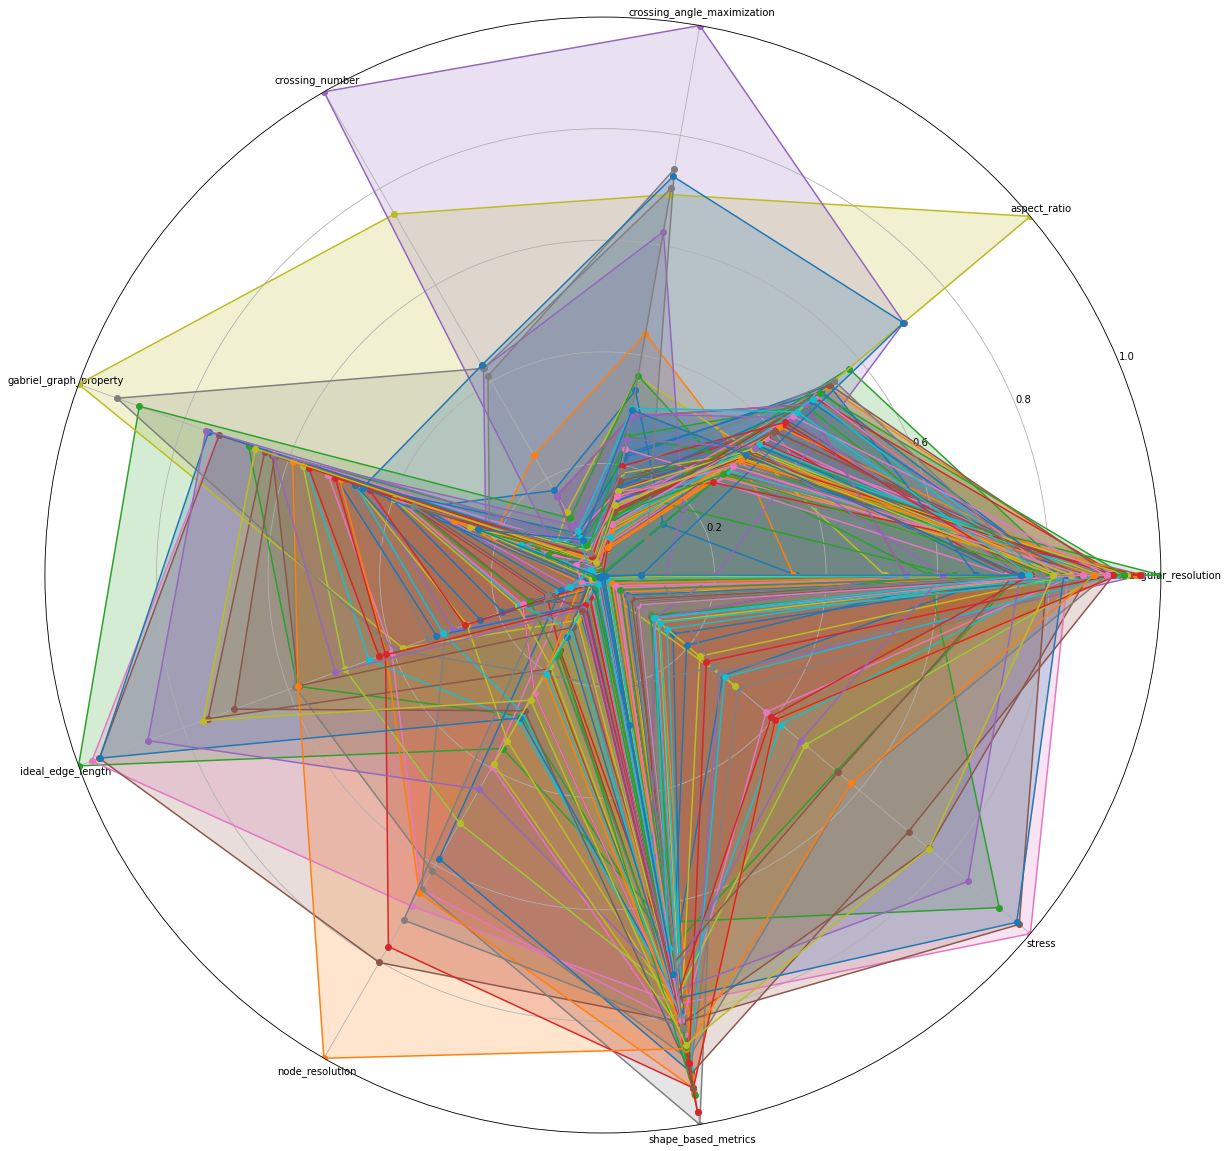

In [71]:
dim = len(quality_metrics_names)
angles = np.linspace(start=0, stop=2 * np.pi, num=dim + 1, endpoint=True)

fig, ax = plt.subplots(1, 1, figsize=(
    20, 24), subplot_kw={'projection': 'polar'})
ax.set_thetagrids(angles[:-1] * 180 / np.pi, quality_metrics_names)
ax.set_rlim(0, 1)
3
for normalized_trial_result in normalized_trial_results:
    concatnate_values = np.concatenate([normalized_trial_result, [
            normalized_trial_result[0]]])
    ax.plot(angles, concatnate_values, 'o-')
    ax.fill(angles, concatnate_values, alpha=0.2)


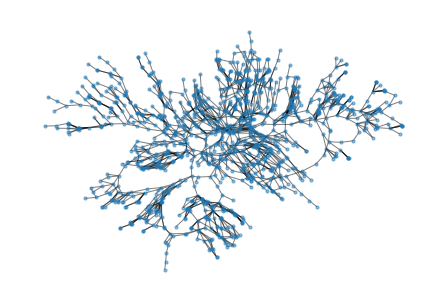

In [76]:
for b in study.best_trials:
    params = {
        'edge_length': b.params['edge_length'],
        'number_of_pivots': b.params['number_of_pivots'],
        'number_of_iterations': b.params['number_of_iterations'],
        'eps': b.params['eps']
    }

    pos = draw_graph(graph, indices, params)
    nx.draw(nx_graph, pos, node_size=10, alpha=0.5)
    plt.show()
    break
